In [1]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time
import random

from utils import *

from numba import jit
import warnings
warnings.filterwarnings("ignore")

In [2]:
L_P = 100
m_P = 0.1
d = 100

r = 1
m_Q, L_Q = r, r

A, b_x, b_y = generate_problem(d=d, m=m_P, L=L_P)
x0 = np.random.uniform(low=-1, high=1, size=(d,))
y0 = np.random.uniform(low=-1, high=1, size=(d,))
z0 = merge(x0, y0)

In [3]:
# -------------- OPERATORS --------------

@jit
def P(x, y):
    grad_x = A @ (y - b_y)
    grad_y = A.T @ (x - b_x)
    return np.concatenate((grad_x, -grad_y), axis=None)

@jit
def Q(x, y, r=r):
    grad_x = r * (x - b_x)
    grad_y = -r * (y - b_y)
    return np.concatenate((grad_x, -grad_y), axis=None)

def R(z):
    x, y = split(z)
    return Q(x,y) + P(x,y)

In [4]:
# Distance to the saddle point

def err_R(z):
    x, y = split(z)
    return np.linalg.norm(x - b_x, ord=2)**2 + np.linalg.norm(y - b_y, ord=2)**2

In [5]:
def extragradient(z0, gamma, error, iters=3000, eps=1e-12):

    z = z0
    z_vals = [z]
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        w = z - gamma * R(z)
        z = z - gamma * R(w)

        z_vals.append(z)
        times.append(time.time() - start)
        err = error(z)
        errs.append(err)
        if err < eps:
            break

    return z_vals, times, errs

In [6]:
# Sub-task generation
def create_B(z_k, theta):
    x_k, y_k = split(z_k)
    
    def B(z):
        x, y = split(z)
        return P(x_k, y_k) + Q(x, y) + (z - z_k)/theta
    return B

@jit
def EAG_V(z0, B, gamma, iters):

    z = z0

    for i in range(0, iters-1):
        
        w = z + (z0 - z)/(i+2) - gamma * B(z)
        z = z + (z0 - z)/(i+2)- gamma * B(w)
        gamma = gamma * (1 - (gamma * L_B)**2 / ((i+1)*(i+3)*(1 - (gamma * L_B)**2)) )

    return z

In [8]:
def extragrad_sliding(z0, gamma, theta, error, gamma_inner, iters_inner, iters=3000, eps=1e-12):

    z = z0
    z_vals = [z]
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        B_tmp = create_B(z, theta)
        u = EAG_V(z, B_tmp, gamma_inner, iters_inner)
        z = z - gamma * R(u)

        z_vals.append(z)
        times.append(time.time() - start)
        err = error(z)
        errs.append(err)
        if err < eps:
            break

    return z_vals, times, errs

In [13]:
iters = 2000
L_B = 2 * L_P + L_Q
gamma_eagv = 0.618/L_B

_, times1, errs1 = extragradient(z0, gamma=1/(3*L_P), error=err_R, iters=iters)
_, times2, errs2 = extragrad_sliding(z0, gamma=0.8/L_P, theta=8/L_P, gamma_inner=gamma_eagv,
                                       iters_inner=4, error=err_R, iters=iters)


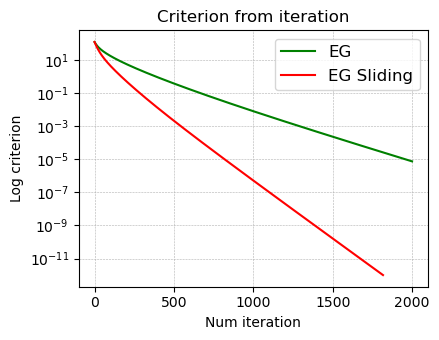

In [25]:
plt.figure(figsize = (4.5,3.5))
plt.plot(range(len(errs1)), errs1, color='g', label='EG')
plt.plot(range(len(errs2)), errs2, color='r', label='EG Sliding')
plt.yscale("log")
plt.xlabel("Num iteration")
plt.ylabel("Log criterion")
plt.grid(True, which="both", linestyle='--', linewidth=0.4)
plt.title('Criterion from iteration')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f'Criterion_from_iteration.pdf')
plt.show()

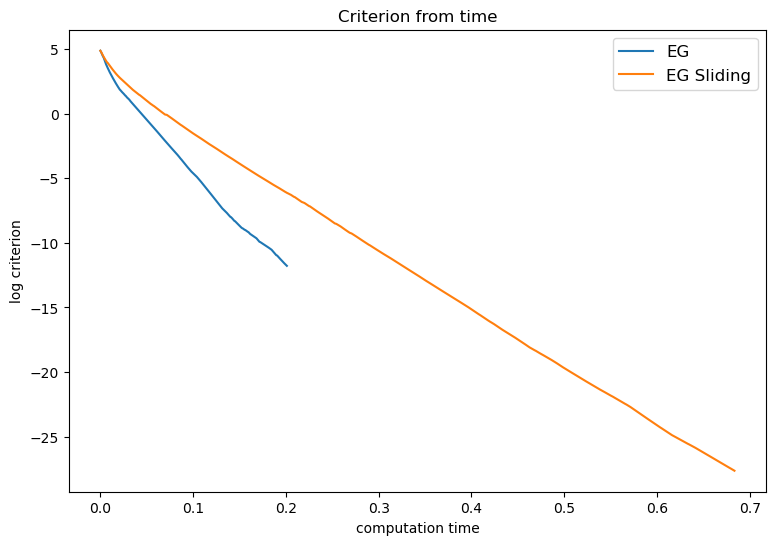

In [15]:
plt.figure(figsize = (4.5,3.5))
plt.plot(times1, np.log(errs1), label='EG')
plt.plot(times2, np.log(errs2), label='EG Sliding')
plt.xlabel("computation time")
plt.ylabel("log criterion")
plt.title('Criterion from time')
plt.legend(fontsize=12)
plt.show()

plt.plot(times1, errs1, color='g', label='EG')
plt.plot(times2, errs2, color='r', label='EG Sliding')
plt.yscale("log")
plt.xlabel("omputation time")
plt.ylabel("Log criterion")
plt.grid(True, which="both", linestyle='--', linewidth=0.4)
plt.title('Criterion from iteration')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f'Criterion_from_iteration.pdf')
plt.show()